pillcam dataset split into neg/pos and trained using resnet.py witouth augmentation or ds normalization.

### Loading images
https://www.tensorflow.org/tutorials/load_data/images

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
model_name = '10x32x224_binary_resnet50' # epoch*batch_size*img_size

NUM_EPOCHS = 10
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
NUM_CHANNELS = 3

In [3]:
data_dir = pathlib.Path('/mnt/sdb/augere_export_class/')

DATASET_SIZE = len(list(data_dir.glob('[!Anatomic]*/*.png')))
class_names = np.array([item.name for item in data_dir.glob('*') if item.name != 'metadata.json'])
# Remove 'anatomic landmarks'
original_class_names = np.delete(class_names, 0)
class_names = np.array(['Negative', 'Positive'])

neg_class_name = 'Normal'
pos_class_names = np.delete(original_class_names, np.where(neg_class_name == original_class_names))

NUM_CLASSES = 2

print ("Positive class names: ", pos_class_names)
print ("Negative class names: ", neg_class_name)

Positive class names:  ['Unknown' 'Protruding lesions' 'Flat lesions' 'Lumen' 'Mucosa'
 'Excavated lesions']
Negative class names:  Normal


In [4]:
# Create a dataset of the file paths
list_ds = tf.data.Dataset.list_files(str(data_dir/'[!Anatomic]*/*'))

In [5]:
# Extract some info about each class

negative_samples = 0
positive_samples = 0
for class_name in original_class_names:
    # Number of samples in 'class_name' folder
    class_samples = len(list(data_dir.glob(class_name+'/*.png')))
    
    if (class_name != 'Normal'):
        negative_samples += class_samples
    else:
        positive_samples += class_samples

print ('Negative samples: {0:5} | {1:5.2f}%'.format(negative_samples, negative_samples/DATASET_SIZE*100))
print ('Positive samples: {0:5} | {1:5.2f}%'.format(positive_samples, positive_samples/DATASET_SIZE*100))
print ('\nTotal number of images:', DATASET_SIZE)

Negative samples:  4617 | 12.23%
Positive samples: 33129 | 87.77%

Total number of images: 37746


Set up pipeline for loading images from given list of paths

In [6]:
def get_label_int(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    bc = parts[-2] == pos_class_names
    nz_cnt = tf.math.count_nonzero(bc)
    if (nz_cnt > 0):
        return tf.reshape(tf.dtypes.cast(tf.fill([1, 1], value=1), tf.uint8),[-1])
    return tf.reshape(tf.dtypes.cast(tf.fill([1, 1], value=0), tf.uint8),[-1])

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
    label = get_label_int(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

Showing an example image/label pair

<Figure size 432x288 with 0 Axes>

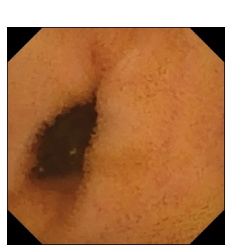

In [7]:
def show_image(img):
    for image, label in img:
        plt.figure()
        plt.figure(frameon=False, facecolor='white')
        plt.title(class_names[label.numpy()][0], fontdict={'color':'white','size':20})
        plt.imshow(image.numpy())
        plt.axis('off')

show_image(labeled_ds.take(1))

### Splitting into training, test and validation data

In [8]:
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)

shuffled_ds = labeled_ds#.shuffle(buffer_size=10000)

train_ds = shuffled_ds.take(train_size)
test_ds = shuffled_ds.skip(train_size)
val_ds = test_ds.skip(val_size)
test_ds = test_ds.take(test_size)

In [9]:
# Print info about the dataset split
def get_size(ds):
    return tf.data.experimental.cardinality(ds).numpy()

print ("{:32} {:>5}".format("Full dataset sample size:", get_size(shuffled_ds)))
print ("{:32} {:>5}".format("Train dataset sample size:", get_size(train_ds)))
print ("{:32} {:>5}".format("Test dataset sample size:", get_size(test_ds)))
print ("{:32} {:>5}".format("Validation dataset sample size:", get_size(val_ds)))

Full dataset sample size:        37746
Train dataset sample size:       26422
Test dataset sample size:         5661
Validation dataset sample size:   5663


In [10]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=3000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
      if isinstance(cache, str):
        ds = ds.cache(cache)
      else:
        ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

# Create training, test and validation dataset
train_ds = prepare_for_training(train_ds, cache="./cache/"+model_name+"_train_ds.tfcache")
test_ds = prepare_for_training(test_ds, cache="./cache/"+model_name+"binary_test_ds.tfcache")
val_ds = prepare_for_training(val_ds, cache="./cache/"+model_name+"binary_val_ds.tfcache")

## Training
https://www.kaggle.com/suniliitb96/tutorial-keras-transfer-learning-with-r

In [12]:
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense

In [14]:
model = Sequential()

model.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))

model.add(Dense(NUM_CLASSES, activation='softmax'))

# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


In [15]:
from tensorflow.python.keras import optimizers

sgd = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer = sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(
        monitor = 'val_loss',
        patience = 3)

cb_checkpointer = ModelCheckpoint(
        filepath = './models/best.hdf5',
        monitor = 'val_loss',
        save_best_only = True,
        mode = 'auto')

In [17]:
history = model.fit(
        train_ds,
        steps_per_epoch = train_size // BATCH_SIZE,
        epochs = NUM_EPOCHS,
        validation_data = test_ds,
        validation_steps = test_size // BATCH_SIZE,
        validation_freq = 1,
        callbacks=[cb_checkpointer, cb_early_stopper])

Epoch 1/10


ValueError: Tried to convert 'y' to a tensor and failed. Error: None values not supported.

In [ ]:
model.load_weights("./models/best.hdf5")

In [ ]:
model.save('models/'+model_name+'.h5')
# new_model = keras.models.load_model('model.h5')

## Validate the results

`Tensorboard`

In [ ]:
# Clear any logs from previous runs (move to .old instead?)
# !rm -rf ./logs/

In [ ]:
# Start tensorboard
%tensorboard --logdir logs

In [ ]:
# !kill 20058

`Keras`
Save/load the model

In [ ]:
result = model.evaluate(
            val_ds,
            steps = val_size//BATCH_SIZE)

print (result)

## Predict new samples

In [ ]:
# Predict 1 image
image, label = next(iter(train_ds))
image = image.numpy()[0]
label = label.numpy()[0]

res = model.predict(np.expand_dims(image, axis=0))

count = 0
for number in res[0]:
    print("{:0.7f} {}".format(number,class_names[count]))
    count += 1
print()

print ("True label:", class_names[label[0]])
print ("Predicted label:", class_names[np.argmax(res[0])])

plt.figure()
plt.imshow(image)
plt.axis('off');

In [ ]:
image, label = next(iter(train_ds))
image = image.numpy()
label = label.numpy()

results = model.predict(image)

idx = 0
for res in results:
    true_label = class_names[label[idx]][0]
    pred_label = class_names[np.argmax(res)]
    print ('{:3}  Label: {:20} Prediction: {}'.format(idx, true_label, pred_label))
    idx += 1